In [1]:
import numpy as np
import pandas as pd
import wandb
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


In [2]:
def get_loss_history(run_id="syncdoth/LIT Training/g6xqeu4l"):
    api = wandb.Api()
    run = api.run(run_id)
    history = run.scan_history(keys=["trainer/global_step", "train_loss_per_batch"], page_size=10000)

    gs = []
    loss = []
    for i, row in tqdm(enumerate(history)):
        if "trainer/global_step" in row and "train_loss_per_batch" in row:
            gs.append(row["trainer/global_step"])
            loss.append(row["train_loss_per_batch"])

    df = pd.DataFrame({"gs": gs, "loss": loss})
    df = df.set_index("gs").dropna()
    return df, run.name


def compute_checkpoint_loss(losses, checkpoint_step=5000, accum_step=2):
    ckpt_iter = checkpoint_step * accum_step

    checkpoint_losses = {}
    loss_hist = []
    for i, loss in enumerate(losses, 1):
        loss_hist.append(loss)
        if i % ckpt_iter == 0:
            checkpoint_losses[i // accum_step] = sum(loss_hist) / len(loss_hist)
            loss_hist = []

    return checkpoint_losses


def compute_improvements(checkpoint_losses):
    improvements = np.array(checkpoint_losses[:-1]) - np.array(checkpoint_losses[1:])
    improvements_percentage = improvements / np.array(checkpoint_losses[:-1])
    return improvements, improvements_percentage

def get_step_to_unfreeze(
        wandb_run_id="syncdoth/LIT Training/g6xqeu4l",
        checkpoint_step=5000,
        accum_step=2,
        loss_improvement_threshold=0.005,
        do_plot=True,
        patience=1,
    ):
    loss_hist, run_name = get_loss_history(wandb_run_id)
    checkpoint_losses = compute_checkpoint_loss(loss_hist["loss"],
                                                checkpoint_step=checkpoint_step,
                                                accum_step=accum_step)
    improvements, improvements_percentage = compute_improvements(list(checkpoint_losses.values()))

    for i, imp in enumerate(improvements_percentage):
        if imp < loss_improvement_threshold:
            patience -= 1
        if patience == 0:
            break
    start_unfreeze_step = list(checkpoint_losses.keys())[i + 1]

    # Plot
    if do_plot:
        plt.plot(list(checkpoint_losses.keys())[1:], improvements_percentage, label="% Impv.")
        plt.axhline(loss_improvement_threshold, color="r", linestyle="--", label="Threshold")
        plt.xlabel("Step")
        plt.ylabel("Improvement ratio")
        plt.title(f"Improvement ratio per checkpoint step\n\nRun: {run_name}")
        plt.legend()
        plt.show()

    return run_name, start_unfreeze_step


0it [00:00, ?it/s]

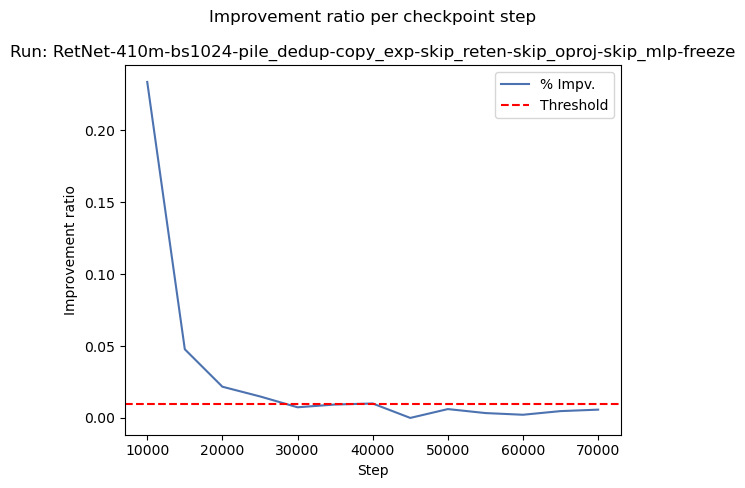

Start unfreezing at: RetNet-410m-bs1024-pile_dedup-copy_exp-skip_reten-skip_oproj-skip_mlp-freeze/iter-030000-ckpt.pth


0it [00:00, ?it/s]

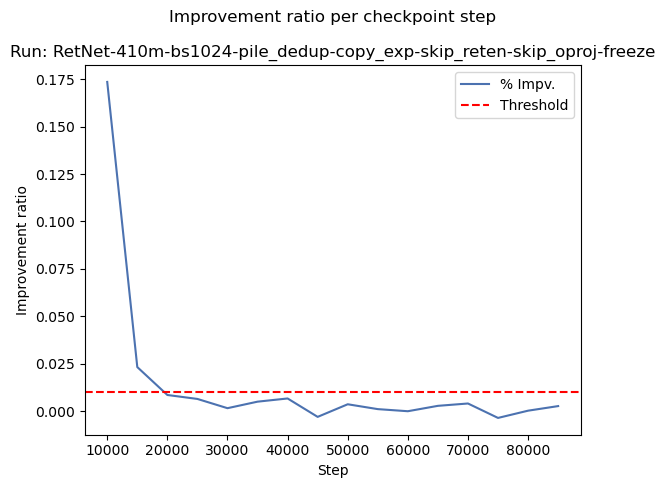

Start unfreezing at: RetNet-410m-bs1024-pile_dedup-copy_exp-skip_reten-skip_oproj-freeze/iter-020000-ckpt.pth


0it [00:00, ?it/s]

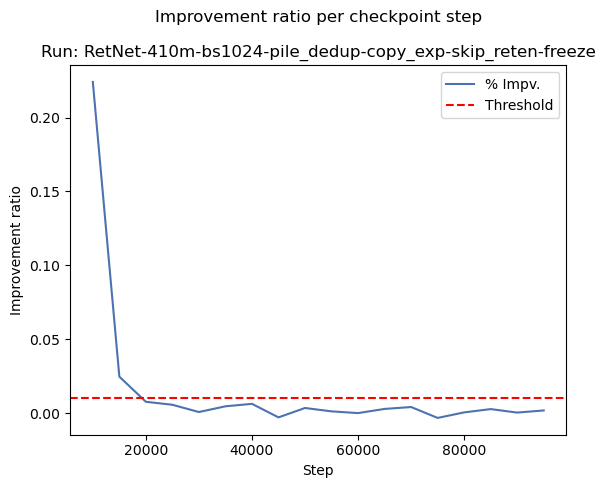

Start unfreezing at: RetNet-410m-bs1024-pile_dedup-copy_exp-skip_reten-freeze/iter-020000-ckpt.pth


In [3]:
run_ids = ["syncdoth/LIT Training/g6xqeu4l", "syncdoth/LIT Training/uat8edgr", "syncdoth/LIT Training/n4jte96s"]

for run_id in run_ids:
    run_name, start_unfreeze_step = get_step_to_unfreeze(
        wandb_run_id=run_id,
        checkpoint_step=5000,
        accum_step=2,
        loss_improvement_threshold=0.01,
        patience=1,
    )
    print(f"Start unfreezing at: {run_name}/iter-{start_unfreeze_step:06}-ckpt.pth")
